In [ ]:
# Necessary
import numpy as np
import pandas as pd
import string,re
from collections import Counter

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [2]:
# Load datasets
train = pd.read_csv('Data/train.csv')[:20]
test = pd.read_csv('Data/test.csv')[:5]
valid = pd.read_csv('Data/valid.csv')[:5]

In [3]:
print("Training Data: ")
print(train.isna().sum())

print("\nValidation Data: ")
print(valid.isna().sum())

print("\nTest Data: ")
print(test.isna().sum())

Training Data: 
en    0
vi    0
dtype: int64

Validation Data: 
en    0
vi    0
dtype: int64

Test Data: 
en    0
vi    0
dtype: int64


In [4]:
print("Training Data: ", train.duplicated().sum())

print("\nValidation Data: ", valid.duplicated().sum())

print("\nTest Data: ", test.duplicated().sum())

Training Data:  0

Validation Data:  0

Test Data:  0


In [5]:
def SentenceCleaning(dataframe: pd.DataFrame) -> pd.DataFrame:

    # remove punctuation
    dataframe['en'] = dataframe['en'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation))) 
    dataframe['vi'] = dataframe['vi'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

    # reduce vocab size 
    dataframe['en'] = dataframe['en'].str.lower() 
    dataframe['vi'] = dataframe['vi'].str.lower()
    
    # clear spaces in the beginning and end
    dataframe['en'] = dataframe['en'].str.strip() 
    dataframe['vi'] = dataframe['vi'].str.strip()

    # reduce multiple spaces to single space
    dataframe['en'] = dataframe['en'].apply(lambda x: re.sub('\s+',' ',x)) 
    dataframe['vi'] = dataframe['vi'].apply(lambda x: re.sub('\s+',' ',x))

    return dataframe

In [6]:
train = SentenceCleaning(train)
valid = SentenceCleaning(valid)
test = SentenceCleaning(test)

In [7]:
def sentence_filter(dataframe: pd.DataFrame) -> pd.DataFrame:
    def is_valid_language_sentence(sentence) -> bool:
        return bool(re.compile(r'^[A-Za-zÀ-ỹà-ỹ0-9\s]*$').match(sentence))
        
    filtered_df = dataframe[dataframe['en'].apply(is_valid_language_sentence) & dataframe['vi'].apply(is_valid_language_sentence)]
    return filtered_df

In [8]:
print("Before filtering: ")
print(f'Train: {train.shape[0]}')
print(f'valid: {valid.shape[0]}')
print(f'test: {test.shape[0]}')

train = sentence_filter(train)
valid = sentence_filter(valid)
test = sentence_filter(test)

print("\nAfter filtering: ")
print(f'Train: {train.shape[0]}')
print(f'valid: {valid.shape[0]}')
print(f'test: {test.shape[0]}')

Before filtering: 
Train: 20
valid: 5
test: 5

After filtering: 
Train: 19
valid: 5
test: 5


In [ ]:
# Preprocess data
vi_train_sentences = train['vi'].values
en_train_sentences = train['en'].values

vi_test_sentences = test['vi'].values
en_test_sentences = test['en'].values

vi_valid_sentences = valid['vi'].values
en_valid_sentences = valid['en'].values

# Tokenize sentences
vi_tokenizer = Tokenizer()
en_tokenizer = Tokenizer()

vi_tokenizer.fit_on_texts(vi_train_sentences)
en_tokenizer.fit_on_texts(en_train_sentences)

vi_train_sequences = vi_tokenizer.texts_to_sequences(vi_train_sentences)
en_train_sequences = en_tokenizer.texts_to_sequences(en_train_sentences)

vi_test_sequences = vi_tokenizer.texts_to_sequences(vi_test_sentences)
en_test_sequences = en_tokenizer.texts_to_sequences(en_test_sentences)

vi_valid_sequences = vi_tokenizer.texts_to_sequences(vi_valid_sentences)
en_valid_sequences = en_tokenizer.texts_to_sequences(en_valid_sentences)

# Pad sequences
max_vi_len = max([len(seq) for seq in vi_train_sequences + vi_test_sequences + vi_valid_sequences])
max_en_len = max([len(seq) for seq in en_train_sequences + en_test_sequences + en_valid_sequences])

vi_train_sequences = pad_sequences(vi_train_sequences, maxlen=max_vi_len, padding='post')
en_train_sequences = pad_sequences(en_train_sequences, maxlen=max_en_len, padding='post')

vi_test_sequences = pad_sequences(vi_test_sequences, maxlen=max_vi_len, padding='post')
en_test_sequences = pad_sequences(en_test_sequences, maxlen=max_en_len, padding='post')

vi_valid_sequences = pad_sequences(vi_valid_sequences, maxlen=max_vi_len, padding='post')
en_valid_sequences = pad_sequences(en_valid_sequences, maxlen=max_en_len, padding='post')

# Assign to variables
vi_train = vi_train_sequences
en_train = en_train_sequences

vi_test = vi_test_sequences
en_test = en_test_sequences

vi_valid = vi_valid_sequences
en_valid = en_valid_sequences

In [18]:
vi_tokenizer

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.callbacks import EarlyStopping

# Define model
embedding_dim = 64
units = 8

# Encoder
encoder_inputs = Input(shape=(max_vi_len,))
encoder_embedding = Embedding(input_dim=len(vi_tokenizer.word_index)+1, output_dim=embedding_dim)(encoder_inputs)
encoder_lstm = LSTM(units, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)

# Decoder
decoder_inputs = Input(shape=(max_en_len,))
decoder_embedding = Embedding(input_dim=len(en_tokenizer.word_index)+1, output_dim=embedding_dim)(decoder_inputs)
decoder_lstm = LSTM(units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h, state_c])
decoder_dense = Dense(len(en_tokenizer.word_index)+1, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
metrics = ['accuracy', 'sparse_categorical_crossentropy']
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=metrics)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 39)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 39, 64)    │     14,464 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 24, 64)    │     11,008 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 8),       │      2,336 │ embedding[0][0]   │
│                     │ (None, 8), (None, │            │                   │
│                     │ 8)]               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 24, 8),   │      2,336 │ embedding_1[0][0… │
│                     │ (None, 8), (None, │            │ lstm[0][1],       │
│                     │ 8)]               │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 24, 172)   │      1,548 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 31,692 (123.80 KB)

 Trainable params: 31,692 (123.80 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
from tensorflow.keras.layers import Attention, Concatenate

# Define model with attention
# Encoder
encoder_inputs = Input(shape=(max_vi_len,))
encoder_embedding = Embedding(input_dim=len(vi_tokenizer.word_index)+1, output_dim=embedding_dim)(encoder_inputs)
encoder_lstm = LSTM(units, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)

# Decoder
decoder_inputs = Input(shape=(max_en_len,))
decoder_embedding = Embedding(input_dim=len(en_tokenizer.word_index)+1, output_dim=embedding_dim)(decoder_inputs)
decoder_lstm = LSTM(units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h, state_c])

# Attention
attention = Attention()
context_vector = attention([decoder_outputs, encoder_outputs])

decoder_concat_input = Concatenate(axis=-1)([context_vector, decoder_outputs])

# Dense layer
decoder_dense = Dense(len(en_tokenizer.word_index)+1, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat_input)

# Define model
model_with_attention = Model([encoder_inputs, decoder_inputs], decoder_outputs)
metrics = ['accuracy', 'sparse_categorical_crossentropy']
model_with_attention.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=metrics)
model_with_attention.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 39)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 39, 64)    │     14,464 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 24, 64)    │     11,008 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 39, 8),   │      2,336 │ embedding_2[0][0] │
│                     │ (None, 8), (None, │            │                   │
│                     │ 8)]               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, 24, 8),   │      2,336 │ embedding_3[0][0… │
│                     │ (None, 8), (None, │            │ lstm_2[0][1],     │
│                     │ 8)]               │            │ lstm_2[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 24, 8)     │          0 │ lstm_3[0][0],     │
│ (Attention)         │                   │            │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 24, 16)    │          0 │ attention[0][0],  │
│ (Concatenate)       │                   │            │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 24, 172)   │      2,924 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,068 (129.17 KB)

 Trainable params: 33,068 (129.17 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
batch_size =8
epochs = 5 

# Prepare target data for training and validation
en_train_out = np.expand_dims(en_train, -1)
en_valid_out = np.expand_dims(en_valid, -1)

early_stopping = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')

# Train without attention
history_without_attention = model.fit([vi_train, en_train], en_train_out, batch_size=batch_size, epochs=epochs, validation_data=([vi_valid, en_valid], en_valid_out), callbacks=[early_stopping])

# Train with attention
history_with_attention = model_with_attention.fit([vi_train, en_train], en_train_out, batch_size=batch_size, epochs=epochs, validation_data=([vi_valid, en_valid], en_valid_out), callbacks=[early_stopping])

Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.1594 - loss: 5.1394 - sparse_categorical_crossentropy: 5.1394 - val_accuracy: 0.8083 - val_loss: 5.0752 - val_sparse_categorical_crossentropy: 5.0752
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4438 - loss: 5.1079 - sparse_categorical_crossentropy: 5.1079 - val_accuracy: 0.8250 - val_loss: 5.0180 - val_sparse_categorical_crossentropy: 5.0180
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4482 - loss: 5.0795 - sparse_categorical_crossentropy: 5.0795 - val_accuracy: 0.8250 - val_loss: 4.9598 - val_sparse_categorical_crossentropy: 4.9598
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4486 - loss: 5.0503 - sparse_categorical_crossentropy: 5.0503 - val_accuracy: 0.8250 - val_loss: 4.8995 - val_sparse_categorical_crossentropy: 4.8995
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4905 - loss: 5.0055 - sparse_categorical_crossentropy: 5.0055 - val_accuracy: 0.8333 - va

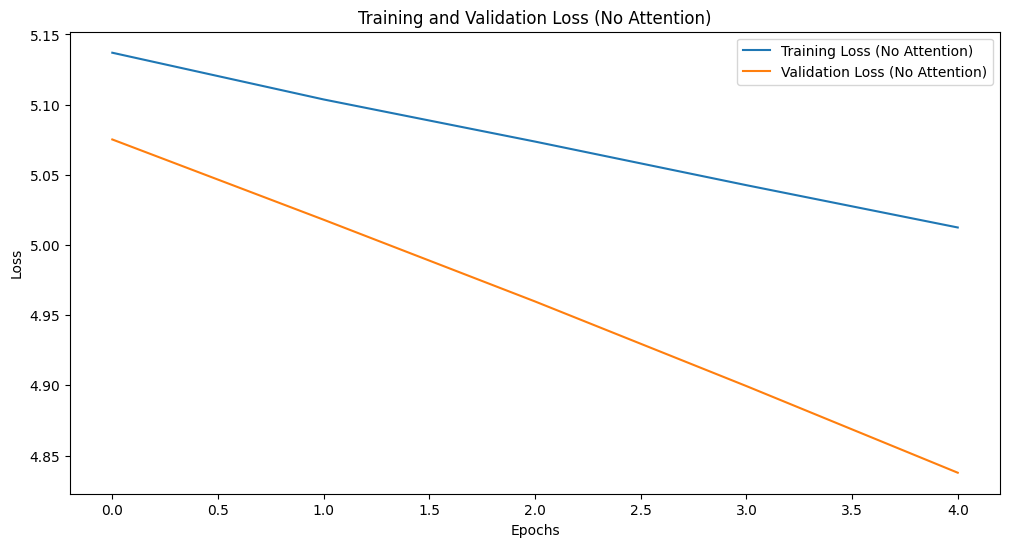

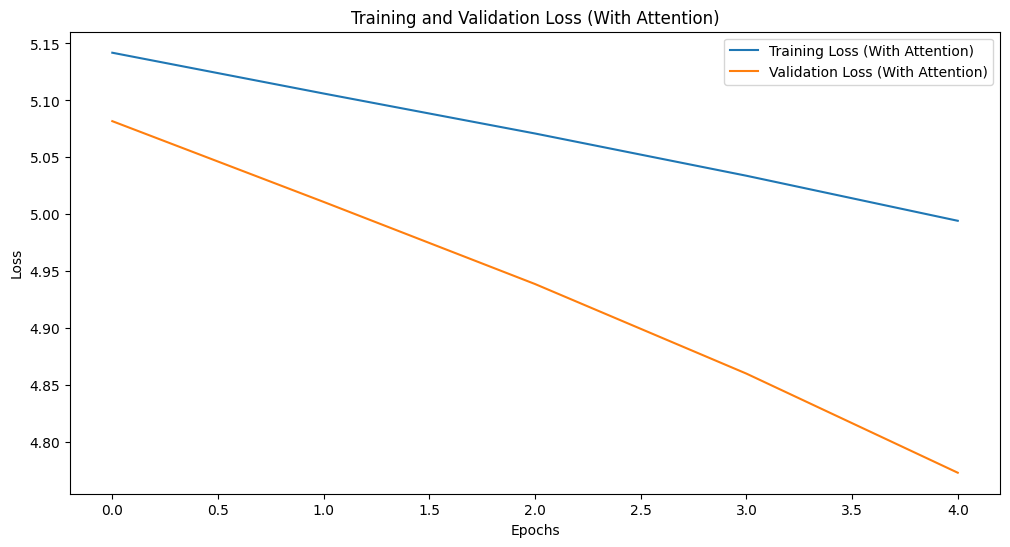

In [13]:
import matplotlib.pyplot as plt

# Plot loss and val_loss for the model without attention
plt.figure(figsize=(12, 6))
plt.plot(history_without_attention.history['loss'], label='Training Loss (No Attention)')
plt.plot(history_without_attention.history['val_loss'], label='Validation Loss (No Attention)')
plt.title('Training and Validation Loss (No Attention)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot loss and val_loss for the model with attention
plt.figure(figsize=(12, 6))
plt.plot(history_with_attention.history['loss'], label='Training Loss (With Attention)')
plt.plot(history_with_attention.history['val_loss'], label='Validation Loss (With Attention)')
plt.title('Training and Validation Loss (With Attention)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
# Save models
model.save('model.h5')
model_with_attention.save('model_with_attention.h5')

In [15]:
# Load models
model = tf.keras.models.load_model('model.h5')
model_with_attention = tf.keras.models.load_model('model_with_attention.h5')

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge
import numpy as np
from sklearn.metrics import f1_score

# Function to calculate F1 score
def calculate_f1_score(reference, candidate):
    reference = list(map(int, reference.split()))
    candidate = list(map(int, candidate.split()))
    return f1_score(reference, candidate, average='weighted')

smooth_fn = SmoothingFunction().method4

# Evaluate models with additional metrics including F1 score
def evaluate_model(model, vi_test, en_test):
    predictions = model.predict([vi_test, en_test])
    bleu_scores = []
    rouge = Rouge()
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []
    f1_scores = []
    for i in range(len(en_test)):
        reference = ' '.join(map(str, en_test[i]))
        candidate = ' '.join(map(str, np.argmax(predictions[i], axis=-1)))
        bleu_scores.append(sentence_bleu([reference.split()], candidate.split(), smoothing_function=smooth_fn))
        rouge_score = rouge.get_scores(candidate, reference)[0]
        rouge1_scores.append(rouge_score['rouge-1']['f'])
        rouge2_scores.append(rouge_score['rouge-2']['f'])
        rougeL_scores.append(rouge_score['rouge-l']['f'])
        f1_scores.append(calculate_f1_score(reference, candidate))
    return {
        'bleu': np.mean(bleu_scores),
        'rouge1': np.mean(rouge1_scores),
        'rouge2': np.mean(rouge2_scores),
        'rougeL': np.mean(rougeL_scores),
        'f1': np.mean(f1_scores)
    }

# Assuming `model` and `model_with_attention` are already defined and trained
scores_no_attention = evaluate_model(model, vi_test, en_test)
scores_with_attention = evaluate_model(model_with_attention, vi_test, en_test)

print("Without Attention")
print(f'Average F1-score: {scores_no_attention["bleu"]}')
print(f'BLEU score: {scores_no_attention["bleu"]}')
print(f'ROUGE-1 score: {scores_no_attention["rouge1"]}')
print(f'ROUGE-2 score: {scores_no_attention["rouge2"]}')
print(f'ROUGE-L score: {scores_no_attention["rougeL"]}')

print("\nWith Attention")
print(f'Average F1-score: {scores_with_attention["bleu"]}')
print(f'BLEU score with attention: {scores_with_attention["bleu"]}')
print(f'ROUGE-1 score with attention: {scores_with_attention["rouge1"]}')
print(f'ROUGE-2 score with attention: {scores_with_attention["rouge2"]}')
print(f'ROUGE-L score with attention: {scores_with_attention["rougeL"]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Without Attention
Average F1-score: 0.7771433382888279
BLEU score: 0.7771433382888279
ROUGE-1 score: 0.26666666202777783
ROUGE-2 score: 0.21111110638580258
ROUGE-L score: 0.26666666202777783

With Attention
Average F1-score: 0.7791371328235749
BLEU score with attention: 0.7791371328235749
ROUGE-1 score with attention: 0.3380952338198697
ROUGE-2 score with attention: 0.22525252067412768
ROUGE-L score with attention: 0.3380952338198697


In [17]:
# model_with_attention = tf.keras.models.load_model('model_with_attention.h5')

# # Function to preprocess the input sentence
# def preprocess_sentence(sentence, tokenizer, max_len):
#     sequence = tokenizer.texts_to_sequences([sentence])
#     padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post')
#     return padded_sequence

# # Function to translate a sentence
# def translate_sentence(model, sentence, vi_tokenizer, en_tokenizer, max_vi_len, max_en_len):
#     # Preprocess the input sentence
#     vi_sequence = preprocess_sentence(sentence, vi_tokenizer, max_vi_len)
    
#     # Initialize the target sequence with the start token
#     en_sequence = np.zeros((1, max_en_len))
    
#     # Predict the translation
#     for i in range(max_en_len):
#         prediction = model.predict([vi_sequence, en_sequence])
#         predicted_id = np.argmax(prediction[0, i, :])
#         en_sequence[0, i] = predicted_id
#         if predicted_id == 0:  # End token
#             break
    
#     # Convert the predicted sequence to words
#     translated_sentence = ' '.join([en_tokenizer.index_word[int(id)] for id in en_sequence[0] if id != 0])
#     return translated_sentence

# # User input
# user_input = input("Enter a Vietnamese sentence: ")

# # Translate the sentence
# translated_sentence = translate_sentence(model_with_attention, user_input, vi_tokenizer, en_tokenizer, max_vi_len, max_en_len)
# print("Translated sentence:", translated_sentence)